In [ ]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

mdrifaturrahman33_levir_cd_path = kagglehub.dataset_download('mdrifaturrahman33/levir-cd')
kenshin2_downloadedmodel_pytorch_default_1_path = kagglehub.model_download('kenshin2/downloadedmodel/PyTorch/default/1')
kenshin2_2ndmodel_pytorch_default_1_path = kagglehub.model_download('kenshin2/2ndmodel/PyTorch/default/1')

print('Data source import complete.')


# Data Preparation

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install torch
!pip install torchvision
!pip install grad-cam


In [ ]:
import torch
print(torch.cuda.is_available())


In [ ]:
## modified and corrected code.


import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

class LEVIRCDDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir_a = os.path.join(images_dir, 'A')  # Pre-change
        self.images_dir_b = os.path.join(images_dir, 'B')  # Post-change
        self.masks_dir = os.path.join(images_dir, 'label')
        self.transform = transform
        # Ensure consistent ordering of files
        self.images_a = sorted(f for f in os.listdir(self.images_dir_a) if f.endswith(('.png', '.jpg', '.jpeg')))
        self.images_b = sorted(f for f in os.listdir(self.images_dir_b) if f.endswith(('.png', '.jpg', '.jpeg')))
        self.masks = sorted(f for f in os.listdir(self.masks_dir) if f.endswith(('.png', '.jpg', '.jpeg')))

    def __len__(self):
        return len(self.images_a)

    def __getitem__(self, idx):
        img_path_a = os.path.join(self.images_dir_a, self.images_a[idx])  # Pre-change
        img_path_b = os.path.join(self.images_dir_b, self.images_b[idx])  # Post-change
        mask_path = os.path.join(self.masks_dir, self.masks[idx])

        # Load images
        image_a = cv2.imread(img_path_a, cv2.IMREAD_COLOR)  # BGR
        image_a = cv2.cvtColor(image_a, cv2.COLOR_BGR2RGB)  # RGB
        image_a = image_a.astype(np.float32) / 255.0  # Normalize to [0, 1]

        image_b = cv2.imread(img_path_b, cv2.IMREAD_COLOR)  # BGR
        image_b = cv2.cvtColor(image_b, cv2.COLOR_BGR2RGB)  # RGB
        image_b = image_b.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Load mask
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Grayscale
        mask = mask.astype(np.float32) / 255.0  # Normalize to [0, 1]

        # Apply transformations consistently
        if self.transform:
            augmented = self.transform(image=image_a, image1=image_b, mask=mask)
            image_a = augmented['image']  # Pre-change
            image_b = augmented['image1']  # Post-change
            mask = augmented['mask']  # Mask

        # Add channel dimension to mask
        mask = mask.unsqueeze(0)

        # Return in the correct order: pre-change, post-change, mask
        return image_a, image_b, mask



# Albumentations transformations
train_transform = A.Compose([
    A.Resize(height=256, width=256),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'image1': 'image'})  # Specify additional target for post-change image

val_transform = A.Compose([
    A.Resize(height=256, width=256),
    # A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
], additional_targets={'image1': 'image'})  # Specify additional target for post-change image

# Datasets
LEVIR_train_dataset = LEVIRCDDataset(
    images_dir="/kaggle/input/levir-cd/LEVIR CD/train",
    transform=train_transform
)

LEVIR_val_dataset = LEVIRCDDataset(
    images_dir="/kaggle/input/levir-cd/LEVIR CD/val",
    transform=val_transform
)

LEVIR_test_dataset = LEVIRCDDataset(
    images_dir="/kaggle/input/levir-cd/LEVIR CD/test",
    transform=val_transform
)

# Dataloaders
LEVIR_train_loader = DataLoader(LEVIR_train_dataset, batch_size=16, shuffle=True)
LEVIR_val_loader = DataLoader(LEVIR_val_dataset, batch_size=16, shuffle=False)
LEVIR_test_loader = DataLoader(LEVIR_test_dataset, batch_size=16, shuffle=False)

# Dataset Statistics

In [ ]:
print(f'Training Dataset Length: {len(LEVIR_train_dataset)}')
print(f'Validation Dataset Length: {len(LEVIR_val_dataset)}')
print(f'Testing Dataset Length: {len(LEVIR_test_dataset)}')

# Data Inspection

In [ ]:
import cv2
import numpy as np
import torch

'''Image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train/22678915_15.png")
Mask=image=cv2.imread("/kaggle/input/massachusetts-buildings-dataset/png/train_labels/22678915_15.png")

print(f'Original mask shape:{Image.shape}')

print(f'Original mask shape:{Mask.shape}')'''

#print(np.unique(Mask))

image1, image2, mask = LEVIR_train_dataset[10]

print(f'Transformed Image shape:{image1.shape}')
print(f'Transformed Image shape:{image2.shape}')
print(f'Transformed mask shape:{mask.shape}')

print(torch.unique(mask))
print(torch.unique(image1))
print(torch.unique(image2))

print(torch.unique(mask).numel())

# Data Visualization

In [ ]:
## old visualisation
import matplotlib.pyplot as plt

# Set up the plot size and remove axes
plt.figure(figsize=(10, 10))  # Set the figure size to be larger

for i in range(3):
    image1, image2, mask = LEVIR_train_dataset[i]

    # Plot Image 1
    plt.subplot(3, 3, i+1)
    plt.imshow(image1.permute(1, 2, 0),cmap='gray')  # Convert tensor to HWC format
    plt.axis('off')  # Remove axes for a cleaner view

    # Plot Image 2
    plt.subplot(3, 3, 3+i+1)
    plt.imshow(image2.permute(1, 2, 0),cmap='gray')  # Convert tensor to HWC format
    plt.axis('off')  # Remove axes

    # Plot Mask
    plt.subplot(3, 3, 6+i+1)
    plt.imshow(mask.permute(1, 2, 0), cmap='gray')  # Display in grayscale
    plt.axis('off')  # Remove axes

plt.show()

In [ ]:
#modified  Set up the plot
plt.figure(figsize=(15, 15))

# Check the first 3 samples
for i in range(3):
    # Get the actual filenames from the dataset
    img_a_filename = LEVIR_train_dataset.images_a[i]
    img_b_filename = LEVIR_train_dataset.images_b[i]
    mask_filename = LEVIR_train_dataset.masks[i]

    # Get the images and mask
    img_a, img_b, mask = LEVIR_train_dataset[i]

    # Plot Pre-change Image (A)
    plt.subplot(3, 3, i+1)
    plt.imshow(img_a.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Pre-change (A):\n{img_a_filename}")

    # Plot Post-change Image (B)
    plt.subplot(3, 3, 3+i+1)
    plt.imshow(img_b.permute(1, 2, 0))
    plt.axis('off')
    plt.title(f"Post-change (B):\n{img_b_filename}")

    # Plot Mask
    plt.subplot(3, 3, 6+i+1)
    plt.imshow(mask.permute(1, 2, 0), cmap='gray')
    plt.axis('off')
    plt.title(f"Mask:\n{mask_filename}")

# Adjust the layout and spacing
plt.tight_layout()

# Save the figure as an image file (e.g., PNG)
plt.savefig('intropage', bbox_inches='tight')  # Use bbox_inches='tight' to save without extra whitespace

# Show the figure
plt.show()


# Siamese U-Net

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Basic ConvBlock used in both encoder and decoder
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

# Encoder block: consists of two convolutions followed by max-pooling
class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(EncoderBlock, self).__init__()
        self.conv1 = ConvBlock(in_channels, out_channels)
        self.conv2 = ConvBlock(out_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        p = self.pool(x)
        return x, p  # Return both the feature map and pooled result

# Decoder block: uses a transposed convolution (upsampling), followed by convolutions
class DecoderBlock(nn.Module):
    def __init__(self, in_channels, skip_channels, out_channels):
        super(DecoderBlock, self).__init__()
        self.upconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        self.conv1 = ConvBlock(in_channels + skip_channels, out_channels)  # Account for concatenation
        self.conv2 = ConvBlock(out_channels, out_channels)

    def forward(self, x, skip):
        x = self.upconv(x)
        x = torch.cat([x, skip], dim=1)  # Concatenate along the channel dimension
        x = self.conv1(x)
        x = self.conv2(x)
        return x

# The main combined Encoder Siamese U-Net architecture
class SiameseUNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(SiameseUNet, self).__init__()

        # Encoder blocks for image 1
        self.encoder1a = EncoderBlock(in_channels, 64)
        self.encoder2a = EncoderBlock(64, 128)
        self.encoder3a = EncoderBlock(128, 256)
        self.encoder4a = EncoderBlock(256, 512)

        # Encoder blocks for image 2
        self.encoder1b = EncoderBlock(in_channels, 64)
        self.encoder2b = EncoderBlock(64, 128)
        self.encoder3b = EncoderBlock(128, 256)
        self.encoder4b = EncoderBlock(256, 512)

        # Bottleneck
        self.bottleneck = ConvBlock(1024, 1024)  # 512 + 512 from both encoders

        # Decoder block (shared between both images)
        self.decoder4 = DecoderBlock(1024, 512, 512)
        self.decoder3 = DecoderBlock(512, 256, 256)
        self.decoder2 = DecoderBlock(256, 128, 128)
        self.decoder1 = DecoderBlock(128, 64, 64)

        # Final convolution to output the segmentation map
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x1, x2):
        # Encoder part for image 1
        e1a, p1a = self.encoder1a(x1)
        e2a, p2a = self.encoder2a(p1a)
        e3a, p3a = self.encoder3a(p2a)
        e4a, p4a = self.encoder4a(p3a)

        # Encoder part for image 2
        e1b, p1b = self.encoder1b(x2)
        e2b, p2b = self.encoder2b(p1b)
        e3b, p3b = self.encoder3b(p2b)
        e4b, p4b = self.encoder4b(p3b)

        # Concatenate the encoder outputs from both images (for each layer)
        concat_e4 = torch.cat([e4a, e4b], dim=1)  # Concatenate along the channel dimension
        concat_e3 = torch.cat([e3a, e3b], dim=1)
        concat_e2 = torch.cat([e2a, e2b], dim=1)
        concat_e1 = torch.cat([e1a, e1b], dim=1)

        # Bottleneck
        b = self.bottleneck(torch.cat([p4a, p4b], dim=1))

        # Decoder part (shared across both images)
        d4 = self.decoder4(b, concat_e4)
        d3 = self.decoder3(d4, concat_e3)
        d2 = self.decoder2(d3, concat_e2)
        d1 = self.decoder1(d2, concat_e1)

        # Final output
        out = self.sigmoid(self.final_conv(d1))
        return out


x1 = torch.randn(1, 3, 256, 256)  # Example image 1
x2 = torch.randn(1, 3, 256, 256)  # Example image 2

# Instantiate the Siamese U-Net model
siamese_unet = SiameseUNet(in_channels=3, out_channels=1)

# Get the output
output = siamese_unet(x1, x2)

print("Output shape:", output.shape)

In [ ]:

# Load the saved model for future use (optional)
#loaded_model = SiameseUNet(in_channels=3, out_channels=1).to(device)
#loaded_model.load_state_dict(torch.load('model.pt'))
#loaded_model.eval()  # Set to evaluation mode for prediction

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loaded_model = SiameseUNet(in_channels=3, out_channels=1).to(device)
loaded_model.load_state_dict(torch.load('/kaggle/input/2ndmodel/pytorch/default/1/right order model (2).pt'))
loaded_model.eval()  # Set to evaluation mode for prediction

# Training Loop

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=60, device='cuda'):
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_train_loss = 0.0
        train_iou_sum = 0
        train_acc_sum = 0
        train_precision_sum = 0
        train_recall_sum = 0
        train_dice_sum = 0
        train_samples = 0

        for inputs1, inputs2, labels in train_loader:  # Change: Get two input images
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs1, inputs2)  # Forward pass with two inputs
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs1.size(0)
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            train_acc_sum += acc * inputs1.size(0)
            train_precision_sum += precision * inputs1.size(0)
            train_recall_sum += recall * inputs1.size(0)
            train_dice_sum += dice * inputs1.size(0)
            train_iou_sum += iou * inputs1.size(0)
            train_samples += inputs1.size(0)

        epoch_train_loss = running_train_loss / train_samples
        epoch_train_iou = train_iou_sum / train_samples
        epoch_train_acc = train_acc_sum / train_samples
        epoch_train_precision = train_precision_sum / train_samples
        epoch_train_recall = train_recall_sum / train_samples
        epoch_train_dice = train_dice_sum / train_samples

        model.eval()
        running_val_loss = 0.0
        val_iou_sum = 0
        val_acc_sum = 0
        val_precision_sum = 0
        val_recall_sum = 0
        val_dice_sum = 0
        val_samples = 0

        with torch.no_grad():
            for inputs1, inputs2, labels in val_loader:  # Change: Get two input images
                inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)
                outputs = model(inputs1, inputs2)  # Forward pass with two inputs
                loss = criterion(outputs, labels)

                running_val_loss += loss.item() * inputs1.size(0)
                acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
                val_acc_sum += acc * inputs1.size(0)
                val_precision_sum += precision * inputs1.size(0)
                val_recall_sum += recall * inputs1.size(0)
                val_dice_sum += dice * inputs1.size(0)
                val_iou_sum += iou * inputs1.size(0)
                val_samples += inputs1.size(0)

        epoch_val_loss = running_val_loss / val_samples
        epoch_val_iou = val_iou_sum / val_samples
        epoch_val_acc = val_acc_sum / val_samples
        epoch_val_precision = val_precision_sum / val_samples
        epoch_val_recall = val_recall_sum / val_samples
        epoch_val_dice = val_dice_sum / val_samples

        print(f'Epoch {epoch+1}/{num_epochs} | '
              f'Train Loss: {epoch_train_loss:.4f}, Val Loss: {epoch_val_loss:.4f} | '
              f'Train IoU: {epoch_train_iou:.4f}, Val IoU: {epoch_val_iou:.4f} | '
              f'Train Acc: {epoch_train_acc:.4f}, Val Acc: {epoch_val_acc:.4f} | '
              f'Train Precision: {epoch_train_precision:.4f}, Val Precision: {epoch_val_precision:.4f} | '
              f'Train Recall: {epoch_train_recall:.4f}, Val Recall: {epoch_val_recall:.4f} | '
              f'Train Dice: {epoch_train_dice:.4f}, Val Dice: {epoch_val_dice:.4f}')

     # Save the final model
    torch.save(model.state_dict(), 'model.pt')

def calculate_metrics(outputs, labels, threshold=0.5):
    predictions = (outputs > threshold).float()
    labels = labels.float()

    tp = torch.sum(predictions * labels)
    tn = torch.sum((1 - predictions) * (1 - labels))
    fp = torch.sum(predictions * (1 - labels))
    fn = torch.sum((1 - predictions) * labels)

    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    dice = 2 * tp / (2 * tp + fp + fn + 1e-6)

    # IoU
    iou = tp / (tp + fp + fn + 1e-6)

    # Accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn + 1e-6)

    return accuracy.item(), precision.item(), recall.item(), dice.item(), iou.item()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize your model
model = SiameseUNet(in_channels=3, out_channels=1).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Train the model with the updated loop
train_model(model, LEVIR_train_loader, LEVIR_val_loader, criterion, optimizer, num_epochs=100, device=device)

# Load the saved model for future use (optional)
#loaded_model = SiameseUNet(in_channels=3, out_channels=1).to(device)
#loaded_model.load_state_dict(torch.load('model.pt'))
#loaded_model.eval()  # Set to evaluation mode for prediction

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


loaded_model = SiameseUNet(in_channels=3, out_channels=1).to(device)
loaded_model.load_state_dict(torch.load('/kaggle/input/2ndmodel/pytorch/default/1/right order model (2).pt'))
loaded_model.eval()  # Set to evaluation mode for prediction

# Testing Loop

In [ ]:
def test_model(model, test_loader, criterion, device='cuda'):
    model.eval()
    running_test_loss = 0.0
    test_iou_sum = 0
    test_acc_sum = 0
    test_precision_sum = 0
    test_recall_sum = 0
    test_dice_sum = 0
    test_samples = 0

    with torch.no_grad():
        for inputs1, inputs2, labels in test_loader:  # Change: Accept two input images
            inputs1, inputs2, labels = inputs1.to(device), inputs2.to(device), labels.to(device)

            # Forward pass with two inputs
            outputs = model(inputs1, inputs2)
            loss = criterion(outputs, labels)

            running_test_loss += loss.item() * inputs1.size(0)

            # Calculate metrics
            acc, precision, recall, dice, iou = calculate_metrics(outputs, labels)
            test_acc_sum += acc * inputs1.size(0)
            test_precision_sum += precision * inputs1.size(0)
            test_recall_sum += recall * inputs1.size(0)
            test_dice_sum += dice * inputs1.size(0)
            test_iou_sum += iou * inputs1.size(0)
            test_samples += inputs1.size(0)

    # Compute average metrics for the epoch
    epoch_test_loss = running_test_loss / test_samples
    epoch_test_iou = test_iou_sum / test_samples
    epoch_test_acc = test_acc_sum / test_samples
    epoch_test_precision = test_precision_sum / test_samples
    epoch_test_recall = test_recall_sum / test_samples
    epoch_test_dice = test_dice_sum / test_samples

    print(f'Test Loss: {epoch_test_loss:.4f} | '
          f'Test IoU: {epoch_test_iou:.4f} | '
          f'Test Acc: {epoch_test_acc:.4f} | '
          f'Test Precision: {epoch_test_precision:.4f} | '
          f'Test Recall: {epoch_test_recall:.4f} | '
          f'Test Dice: {epoch_test_dice:.4f}')

    # return {
    #     'loss': epoch_test_loss,
    #     'iou': epoch_test_iou,
    #     'accuracy': epoch_test_acc,
    #     'precision': epoch_test_precision,
    #     'recall': epoch_test_recall,
    #     'dice': epoch_test_dice
    # }

# Evaluate the model on the test set
test_results = test_model(model, LEVIR_test_loader, criterion, device=device)

# **HIRESCAM implementation**

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import cv2

class HiResCAM:
    def __init__(self, model):
        self.model = model
        self.model.eval()

        # Hooks for pre-change branch
        self.pre_features = {}
        self.pre_gradients = {}

        # Hooks for post-change branch
        self.post_features = {}
        self.post_gradients = {}

        # Hooks for bottleneck
        self.bottleneck_features = None
        self.bottleneck_gradients = None

        # Track if hooks are registered
        self.hooks_registered = False
        self.forward_hooks = []
        self.backward_hooks = []

        print("HiResCAM initialized for Siamese U-Net model")

    def register_hooks(self):
        """Register forward and backward hooks on key layers"""
        # Clear any existing hooks
        self.remove_hooks()

        # Register hooks for pre-change branch (encoder4a)
        pre_target_layer = self.model.encoder4a.conv2.conv

        def pre_save_features(module, input, output):
            self.pre_features['encoder4a'] = output.detach()

        def pre_save_gradients(module, grad_input, grad_output):
            self.pre_gradients['encoder4a'] = grad_output[0].detach()

        pre_forward_hook = pre_target_layer.register_forward_hook(pre_save_features)
        pre_backward_hook = pre_target_layer.register_full_backward_hook(pre_save_gradients)
        self.forward_hooks.append(pre_forward_hook)
        self.backward_hooks.append(pre_backward_hook)

        # Register hooks for post-change branch (encoder4b)
        post_target_layer = self.model.encoder4b.conv2.conv

        def post_save_features(module, input, output):
            self.post_features['encoder4b'] = output.detach()

        def post_save_gradients(module, grad_input, grad_output):
            self.post_gradients['encoder4b'] = grad_output[0].detach()

        post_forward_hook = post_target_layer.register_forward_hook(post_save_features)
        post_backward_hook = post_target_layer.register_full_backward_hook(post_save_gradients)
        self.forward_hooks.append(post_forward_hook)
        self.backward_hooks.append(post_backward_hook)

        # Register hooks for bottleneck
        bottleneck_layer = self.model.bottleneck.conv

        def bottleneck_save_features(module, input, output):
            self.bottleneck_features = output.detach()

        def bottleneck_save_gradients(module, grad_input, grad_output):
            self.bottleneck_gradients = grad_output[0].detach()

        bottleneck_forward_hook = bottleneck_layer.register_forward_hook(bottleneck_save_features)
        bottleneck_backward_hook = bottleneck_layer.register_full_backward_hook(bottleneck_save_gradients)
        self.forward_hooks.append(bottleneck_forward_hook)
        self.backward_hooks.append(bottleneck_backward_hook)

        self.hooks_registered = True
        print("✓ Successfully registered hooks on pre-branch, post-branch, and bottleneck layers")

    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.forward_hooks:
            hook.remove()
        for hook in self.backward_hooks:
            hook.remove()

        self.forward_hooks = []
        self.backward_hooks = []
        self.hooks_registered = False
        print("✓ Removed all hooks")

    def generate_cam(self, features, gradients):
        """Generate CAM from features and gradients"""
        # Weight the channels by corresponding gradients
        weights = torch.mean(gradients, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * features, dim=1, keepdim=True)

        # Apply ReLU to focus on positive contributions
        cam = torch.relu(cam)

        # Normalize the CAM
        if torch.max(cam) > 0:
            cam = cam / torch.max(cam)

        return cam

    def generate_cams(self, pre_image, post_image, target_mask=None):
        """Generate CAMs for pre-image, post-image, and combined"""
        if not self.hooks_registered:
            print("Hooks not registered. Registering hooks now...")
            self.register_hooks()

        # Ensure inputs have batch dimension
        if pre_image.dim() == 3:
            pre_image = pre_image.unsqueeze(0)
        if post_image.dim() == 3:
            post_image = post_image.unsqueeze(0)

        # Move to the same device as the model
        device = next(self.model.parameters()).device
        pre_image = pre_image.to(device)
        post_image = post_image.to(device)

        # Enable gradient tracking
        pre_image.requires_grad = True
        post_image.requires_grad = True

        # Forward pass
        print("Performing forward pass...")
        prediction = self.model(pre_image, post_image)

        # If no target mask is provided, use the prediction
        if target_mask is None:
            target = prediction
        else:
            target_mask = target_mask.to(device)
            if target_mask.dim() == 3:
                target_mask = target_mask.unsqueeze(0)
            target = target_mask

        # Backward pass
        print("Performing backward pass...")
        self.model.zero_grad()
        prediction.backward(gradient=target)

        # Generate CAMs
        print("Generating CAMs...")
        pre_cam = self.generate_cam(self.pre_features['encoder4a'], self.pre_gradients['encoder4a'])
        post_cam = self.generate_cam(self.post_features['encoder4b'], self.post_gradients['encoder4b'])

        # Generate combined CAM from bottleneck
        combined_cam = None
        if self.bottleneck_features is not None and self.bottleneck_gradients is not None:
            combined_cam = self.generate_cam(self.bottleneck_features, self.bottleneck_gradients)

        # Resize CAMs to match input size
        pre_cam = torch.nn.functional.interpolate(
            pre_cam, size=(pre_image.shape[2], pre_image.shape[3]),
            mode='bilinear', align_corners=False
        )

        post_cam = torch.nn.functional.interpolate(
            post_cam, size=(post_image.shape[2], post_image.shape[3]),
            mode='bilinear', align_corners=False
        )

        if combined_cam is not None:
            combined_cam = torch.nn.functional.interpolate(
                combined_cam, size=(pre_image.shape[2], pre_image.shape[3]),
                mode='bilinear', align_corners=False
            )

        # Convert to numpy arrays
        pre_cam_np = pre_cam.squeeze().cpu().detach().numpy()
        post_cam_np = post_cam.squeeze().cpu().detach().numpy()
        combined_cam_np = combined_cam.squeeze().cpu().detach().numpy() if combined_cam is not None else None

        print("✓ Successfully generated CAMs for pre-image, post-image, and combined")

        return pre_cam_np, post_cam_np, combined_cam_np

    def overlay_cam(self, image, cam, colormap=cv2.COLORMAP_JET, alpha=0.5):
        """Overlay CAM on the original image"""
        # Convert image tensor to numpy array
        if isinstance(image, torch.Tensor):
            image_np = image.squeeze().permute(1, 2, 0).cpu().detach().numpy()
        else:
            image_np = image

        # Ensure image is in range [0, 1]
        if image_np.max() > 1.0:
            image_np = image_np / 255.0

        # Create heatmap
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), colormap)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

        # Overlay heatmap on image
        overlay = alpha * heatmap + (1 - alpha) * image_np

        # Normalize to [0, 1]
        overlay = overlay / overlay.max()

        return overlay

print("HiResCAM module is ready to use!")
print("To use: Initialize with your model, then call generate_cams() with pre and post images")


In [ ]:
# Set seed for reproducibility
random.seed(42)

# Check if dataset exists and print its length
print(f"LEVIR_test_dataset length: {len(LEVIR_test_dataset)}")

# Select random indices
indices = random.sample(range(len(LEVIR_test_dataset)), 10)
print(f"Selected sample indices: {indices}")

# Preview the samples
plt.figure(figsize=(15, 5 * len(indices)))

for i, idx in enumerate(indices):
    # Get the sample
    pre_image, post_image, mask = LEVIR_test_dataset[idx]

    # Convert tensors to numpy arrays for visualization
    pre_image_np = pre_image.permute(1, 2, 0).cpu().numpy()
    post_image_np = post_image.permute(1, 2, 0).cpu().numpy()
    mask_np = mask.squeeze().cpu().numpy()

    # Plot
    plt.subplot(len(indices), 3, 3*i + 1)
    plt.imshow(pre_image_np)
    plt.title(f"Pre-Change (Index: {idx})")
    plt.axis('off')

    plt.subplot(len(indices), 3, 3*i + 2)
    plt.imshow(post_image_np)
    plt.title(f"Post-Change (Index: {idx})")
    plt.axis('off')

    plt.subplot(len(indices), 3, 3*i + 3)
    plt.imshow(mask_np, cmap='gray')
    plt.title(f"Ground Truth (Index: {idx})")
    plt.axis('off')

plt.tight_layout()
plt.savefig('sample_preview.png', bbox_inches='tight')
plt.show()

print("✓ Sample preview completed and saved as 'sample_preview.png'")


# 2nd style of visualisation

In [ ]:
# Make sure you've already run the HiResCAM class definition cell
# and the sample preview cell that defined 'indices'
# Initialize HiResCAM with your loaded model
hirescam = HiResCAM(loaded_model)  # Use loaded_model instead of model

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Import additional libraries for visualization
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import os

# Process each sample individually
for i, idx in enumerate(indices):
    print(f"\n--- Processing sample {i+1}/{len(indices)} (Index: {idx}) ---")

    # Get the sample
    pre_image, post_image, ground_truth = LEVIR_test_dataset[idx]

    # Add batch dimension and move to device
    pre_image_batch = pre_image.unsqueeze(0).to(device)
    post_image_batch = post_image.unsqueeze(0).to(device)
    ground_truth_batch = ground_truth.unsqueeze(0).to(device)

    # Get model prediction
    print("Generating prediction...")
    with torch.no_grad():
        prediction = loaded_model(pre_image_batch, post_image_batch)
        binary_prediction = (prediction > 0.5).float()

    # Generate CAMs
    print("Generating HiResCAM visualizations...")
    pre_cam, post_cam, combined_cam = hirescam.generate_cams(pre_image_batch, post_image_batch)

    # Create overlays
    pre_overlay = hirescam.overlay_cam(pre_image, pre_cam)
    post_overlay = hirescam.overlay_cam(post_image, post_cam)

    # Determine which image has higher activation for adaptive overlay
    pre_activation = np.mean(pre_cam)
    post_activation = np.mean(post_cam)

    # Handle the case where activations might be zero
    if pre_activation > 0 and post_activation > 0:
        if pre_activation >= post_activation:
            base_image = pre_image
            ratio = pre_activation / post_activation
            overlay_text = f"Pre-change image has {ratio:.2f}x higher attention than post-change"
        else:
            base_image = post_image
            ratio = post_activation / pre_activation
            overlay_text = f"Post-change image has {ratio:.2f}x higher attention than pre-change"
    else:
        # Handle the case where one or both activations are zero
        if pre_activation > 0:
            base_image = pre_image
            overlay_text = "Pre-change image has higher attention (post-change has none)"
        elif post_activation > 0:
            base_image = post_image
            overlay_text = "Post-change image has higher attention (pre-change has none)"
        else:
            base_image = pre_image  # Default to pre-image if both are zero
            overlay_text = "Both images have minimal attention"

    combined_overlay = hirescam.overlay_cam(base_image, combined_cam) if combined_cam is not None else None

    # Convert tensors to numpy for visualization
    pre_image_np = pre_image.permute(1, 2, 0).cpu().numpy()
    post_image_np = post_image.permute(1, 2, 0).cpu().numpy()
    ground_truth_np = ground_truth.squeeze().cpu().numpy()
    prediction_np = binary_prediction.squeeze().cpu().detach().numpy()

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))

    # Original images and masks
    plt.subplot(2, 4, 1)
    plt.imshow(pre_image_np)
    plt.title("Pre-Change Image")
    plt.axis('off')

    plt.subplot(2, 4, 2)
    plt.imshow(post_image_np)
    plt.title("Post-Change Image")
    plt.axis('off')

    plt.subplot(2, 4, 3)
    plt.imshow(ground_truth_np, cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(2, 4, 4)
    plt.imshow(prediction_np, cmap='gray')
    plt.title("Model Prediction")
    plt.axis('off')

    # CAM visualizations
    plt.subplot(2, 4, 5)
    plt.imshow(pre_overlay)
    plt.title("Pre-Change HiResCAM")
    plt.axis('off')

    plt.subplot(2, 4, 6)
    plt.imshow(post_overlay)
    plt.title("Post-Change HiResCAM")
    plt.axis('off')

    plt.subplot(2, 4, 7)
    if combined_overlay is not None:
        plt.imshow(combined_overlay)
        plt.title("Adaptive Combined HiResCAM")
        # Move text closer to the image
        plt.text(0.5, -0.05, overlay_text,
                 ha='center', va='center', transform=plt.gca().transAxes, fontsize=10)
    else:
        plt.text(0.5, 0.5, "Combined CAM not available",
                 horizontalalignment='center', verticalalignment='center')
    plt.axis('off')

    # Create attention reference in place of the distribution plot
    ax = plt.subplot(2, 4, 8)

    # Create custom colormap for smooth transition from blue to red
    colors = [(0, 0, 1), (0, 1, 1), (0, 1, 0), (1, 1, 0), (1, 0, 0)]  # Blue -> Cyan -> Green -> Yellow -> Red
    cmap_name = 'attention_cmap'
    custom_cmap = mcolors.LinearSegmentedColormap.from_list(cmap_name, colors)

    # Calculate dimensions for the gradient and labels
    gradient_width = 40  # Width of the gradient bar
    total_width = 100    # Total width of the gradient + labels area
    height = 256         # Height of the gradient

    # Create vertical gradient - REVERSED to go from low (bottom) to high (top)
    gradient = np.linspace(0,1 ,height).reshape(-1, 1)  # Note: 1 to 0 instead of 0 to 1
    gradient = np.hstack([gradient] * gradient_width)

    # Create a wider canvas to include labels
    canvas = np.zeros((height, total_width, 4))  # RGBA canvas

    # Place the gradient on the left side of the canvas
    for i in range(gradient_width):
        for j in range(height):
            color = custom_cmap(gradient[j, 0])
            canvas[j, i] = color

    # Display the canvas
    ax.imshow(canvas, aspect='auto')

    # Add attention level labels directly next to the gradient
    # Corrected order from low (bottom) to high (top)
    attention_levels = [
        ("Extremely Low", 0.05),
        ("Very Low", 0.20),
        ("Low", 0.35),
        ("Medium", 0.55),
        ("High", 0.75),
        ("Extremely High", 0.95)
    ]

    for label, pos in attention_levels:
        y_pos = int(pos * height)
        ax.text(gradient_width + 5, y_pos, label,
                ha='left', va='center', fontsize=12,
                color='black', fontweight='bold')

    ax.set_title("Scale of Model Attention", fontsize=14)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')

    # Save the main figure with tight layout
    plt.tight_layout()
    plt.savefig(f'hirescam_sample_{idx}.png', bbox_inches='tight', dpi=300)
    plt.show()

    print(f"✓ Visualization for sample {i+1} (Index: {idx}) completed and saved as 'hirescam_sample_{idx}.png'")

    # Clear memory
    plt.close(fig)
    torch.cuda.empty_cache() if torch.cuda.is_available() else None

    # Remove hooks after processing each sample
    hirescam.remove_hooks()

print("\n✓ All visualizations completed!")


In [ ]:
# Install necessary dependencies
!pip install -q pydot
!apt-get -qq install graphviz

# Clone the PlotNeuralNet repository
!git clone https://github.com/HarisIqbal88/PlotNeuralNet.git


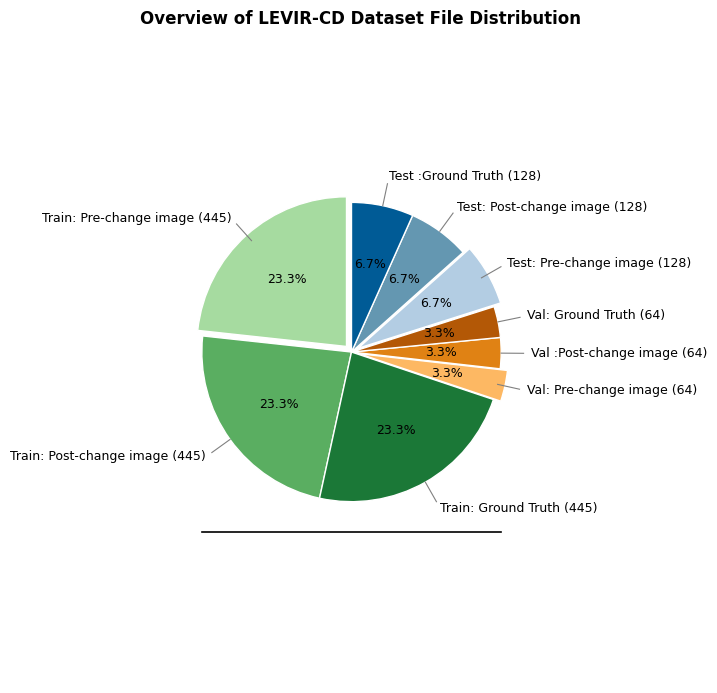

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data: counts for each subcategory
sizes = [
    445, 445, 445,  # Train: Pre-change, Post-change, Ground Truth
    64, 64, 64,     # Validation: Pre-change, Post-change, Ground Truth
    128, 128, 128   # Test: Pre-change, Post-change, Ground Truth
]

# Labels with counts
labels = [
    'Train: Pre-change image (445)', 'Train: Post-change image (445)', 'Train: Ground Truth (445)',
    'Val: Pre-change image (64)', 'Val :Post-change image (64)', 'Val: Ground Truth (64)',
    'Test: Pre-change image (128)', 'Test: Post-change image (128)', 'Test :Ground Truth (128)'
]

# Colors grouped by dataset split
colors = [
    '#a6dba0', '#5aae61', '#1b7837',  # Train greens
    '#fdb863', '#e08214', '#b35806',  # Validation oranges
    '#b3cde3', '#6497b1', '#005b96'   # Test blues
]

# Explode to separate core groups (Train, Val, Test)
explode = [0.05, 0, 0, 0.05, 0, 0, 0.05, 0, 0]

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 9

fig, ax = plt.subplots(figsize=(7, 7))

wedges, texts, autotexts = ax.pie(
    sizes,
    labels=labels,
    colors=colors,
    autopct='%1.1f%%',
    pctdistance=0.6,        # Percentages inside slices, closer to center
    labeldistance=1.15,     # Labels outside slices
    explode=explode,
    startangle=90,
    wedgeprops=dict(edgecolor='w'),
    textprops={'fontfamily': 'Times New Roman', 'fontsize': 9}
)

# Improve label alignment and add leader lines
for text, wedge in zip(texts, wedges):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    horizontalalignment = 'left' if x > 0 else 'right'
    text.set_horizontalalignment(horizontalalignment)
    # Optionally, shift labels slightly further out for clarity
    text.set_position((x * 1.2, y * 1.2))

# Draw leader lines from slice edge to label
for wedge, text in zip(wedges, texts):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang))
    y = np.sin(np.deg2rad(ang))
    # Start point: edge of pie slice (radius=1)
    start = (x, y)
    # End point: label position (shifted out)
    end = (x * 1.15, y * 1.15)
    ax.plot([start[0], end[0]], [start[1], end[1]], color='gray', linewidth=0.8)

ax.axis('equal')
ax.axis('off')

plt.title('Overview of LEVIR-CD Dataset File Distribution', fontsize=12, fontweight='bold')

# Small horizontal line below chart
plt.plot([-1, 1], [-1.2, -1.2], color='black', linewidth=1.2)

plt.tight_layout()

# Save the figure (adjust path as needed)
plt.savefig('/kaggle/working/levir_cd_flat_piechart_labels_outside.png', dpi=300, bbox_inches='tight')

plt.show()


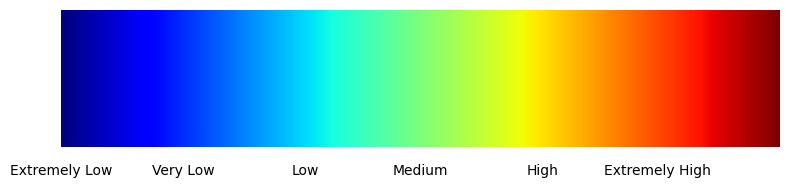

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Gradient parameters
width, height = 8, 2
gradient = np.linspace(0, 1, 256).reshape(1, -1)  # Horizontal gradient
gradient = np.vstack([gradient]*50)  # Adjust thickness as needed

# IEEE font settings (Times New Roman, 10pt)
font = {'family': 'Times New Roman', 'size': 10}

# Create figure
fig, ax = plt.subplots(figsize=(width, height))

# Show gradient (blue to red)
ax.imshow(gradient, aspect='auto', cmap=plt.get_cmap('jet'), extent=[0, 1, 0, 1])

# Remove axes
ax.axis('off')

# Label positions (relative to width)
label_positions = [0, 0.17, 0.34, 0.5, 0.67, 0.83]
labels = [
    'Extremely Low',
    'Very Low',
    'Low',
    'Medium',
    'High',
    'Extremely High'
]

# Add labels below the bar
for pos, label in zip(label_positions, labels):
    ax.text(pos, -0.12, label, ha='center', va='top', fontdict=font)



plt.tight_layout()

# Save the figure (adjust path as needed)
plt.savefig('/kaggle/working/attention.png', dpi=300, bbox_inches='tight')

plt.show()